In [259]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

<font size="8" color="Black">Part 1 and 2</font>

,RegionName,Average Price,Date,Year
0,"New York, NY",179016.866340,2000-01-31,2000
1,"Los Angeles, CA",225229.750975,2000-01-31,2000
2,"Chicago, IL",140260.935566,2000-01-31,2000
3,"Dallas, TX",128720.957496,2000-01-31,2000
4,"Houston, TX",117733.849496,2000-01-31,2000
...,...,...,...,...
1390,"New York, NY",568543.199929,2023-03-31,2023
1391,"Los Angeles, CA",873619.353300,2023-03-31,2023
1392,"Chicago, IL",289343.730912,2023-03-31,2023
1393,"Dallas, TX",368252.408975,2023-03-31,2023


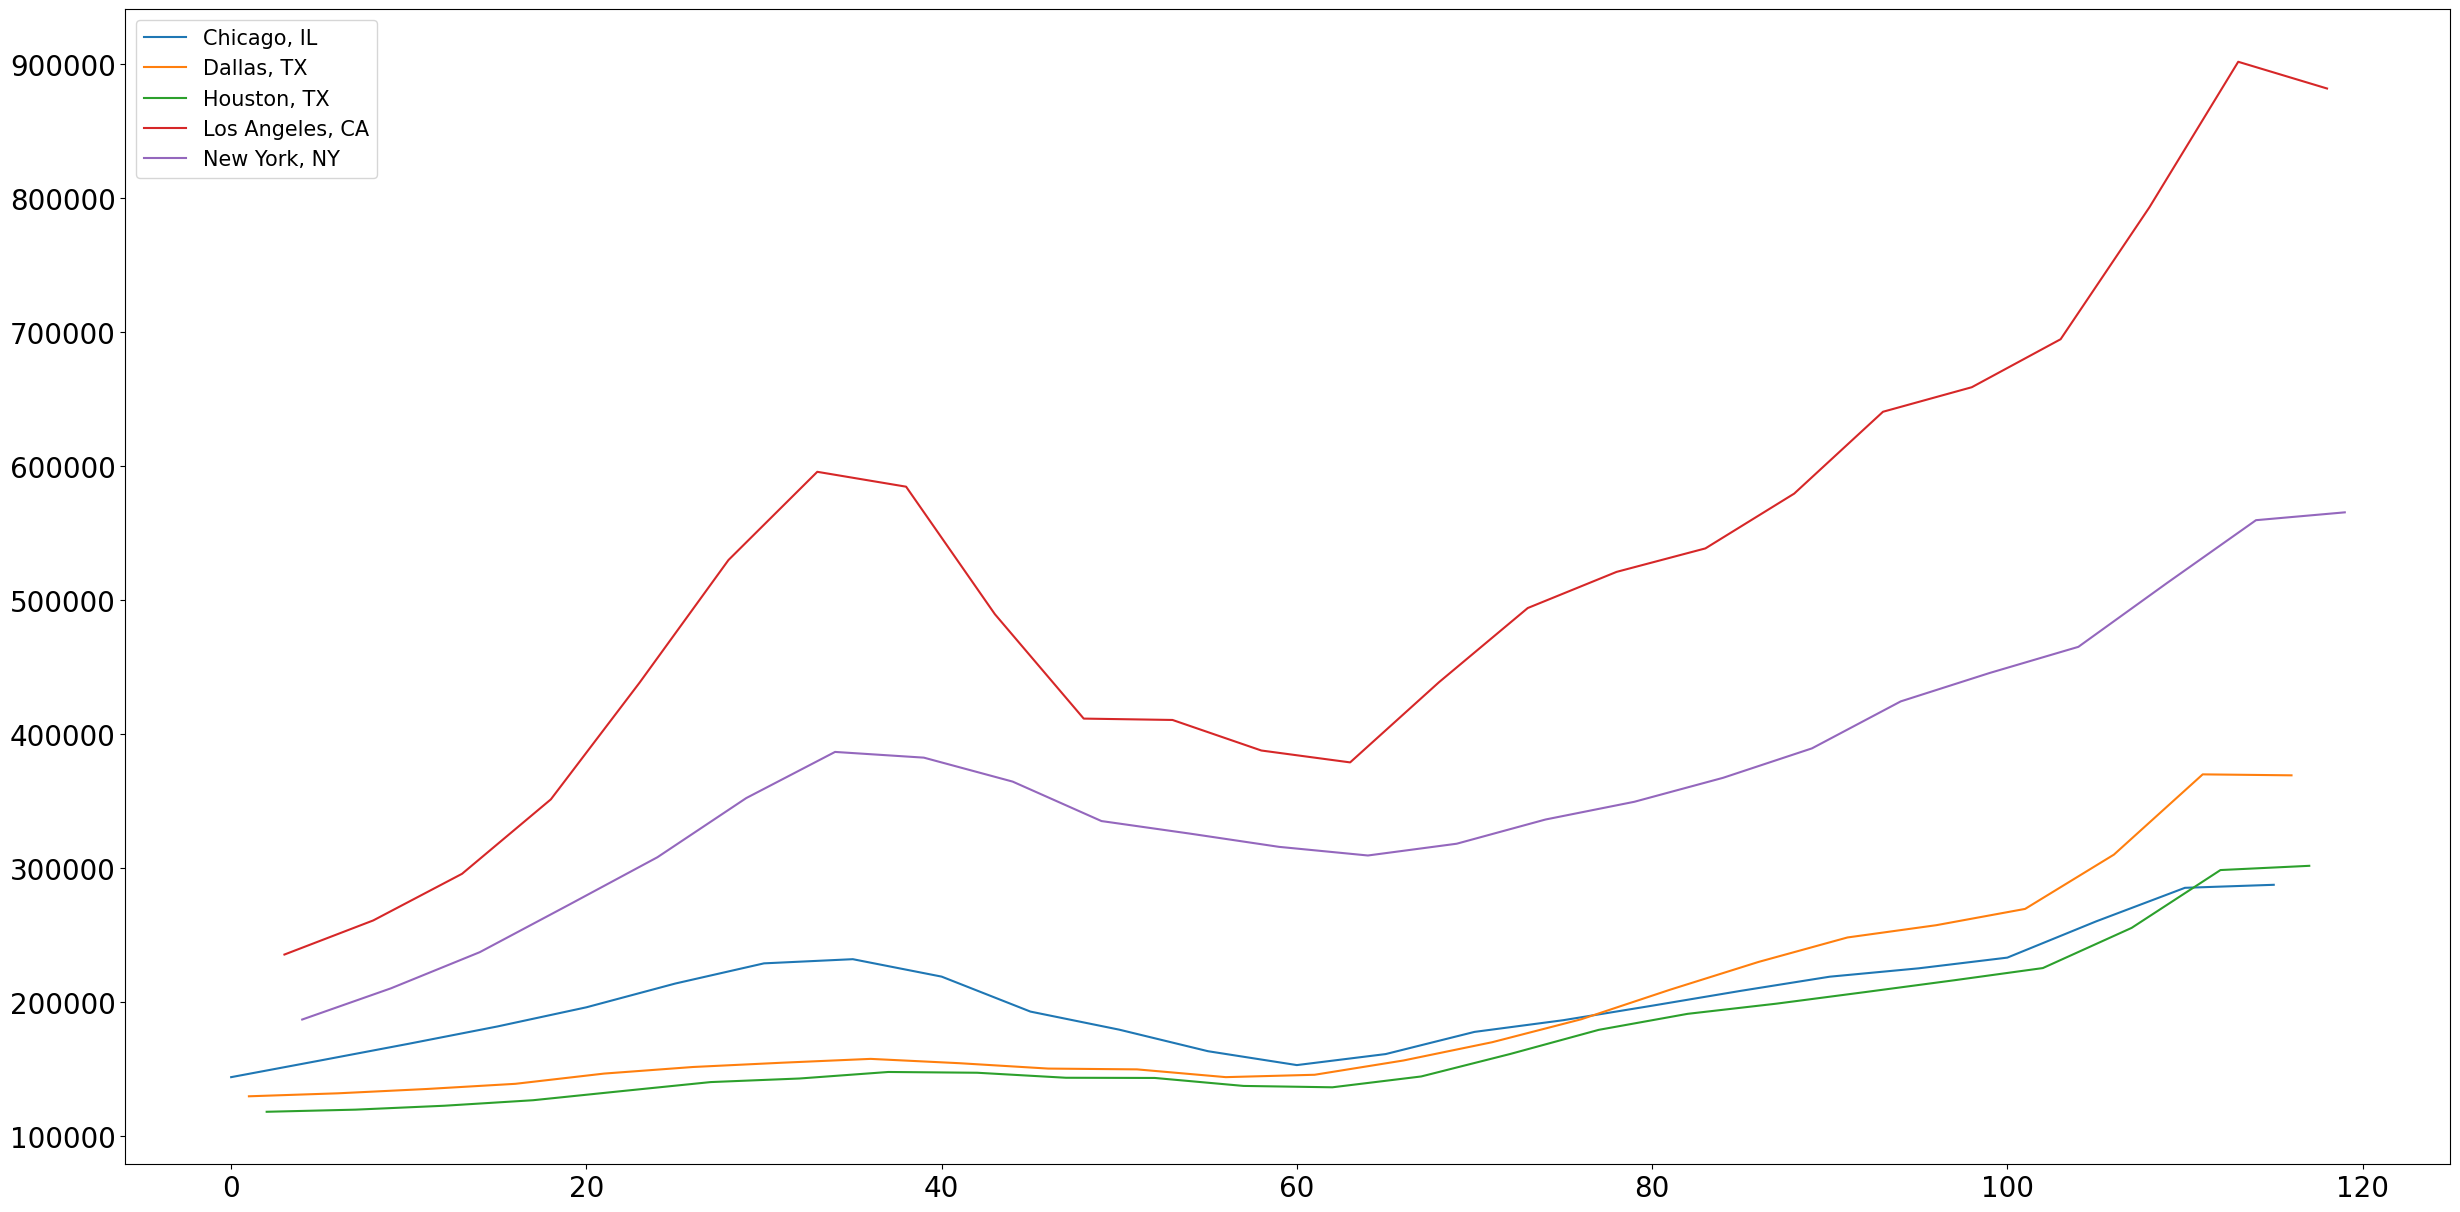

,Year,City,Average Price
0,2000,"Chicago, IL",144210.742048
1,2000,"Dallas, TX",129926.866266
2,2000,"Houston, TX",118371.138355
3,2000,"Los Angeles, CA",235702.243852
4,2000,"New York, NY",187211.522252
...,...,...,...
115,2023,"Chicago, IL",287741.033592
116,2023,"Dallas, TX",369431.030591
117,2023,"Houston, TX",301907.494031
118,2023,"Los Angeles, CA",881948.352043


In [260]:
# Extract data of housing price average f| 5 most populated cities in US
#pd.set_option('display.max_rows', 500)
prices = pd.read_csv('Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv').head(6).tail(-1)
prices = pd.melt(prices, id_vars=['RegionName'], value_vars=prices.columns[5:])
prices['Date'] = pd.to_datetime(prices['variable'])
prices['Date'] = prices['Date'].astype('str')
prices = prices.drop('variable', axis=1).rename(columns={'value': 'Average Price'})
prices['Date'] = pd.DatetimeIndex(prices['Date'])
prices['Year'] = pd.DatetimeIndex(prices['Date']).year
prices.drop(columns='Date', axis=1)
display(prices)
prices = prices.groupby(['Year', 'RegionName']).aggregate(np.mean)
prices = prices.reset_index()
# Plot the avergae house price per month for each city
fig, ax = plt.subplots()
prices = prices.rename(columns={'RegionName': 'City'})
prices.groupby('City')['Average Price'].plot(x='Year', y='Average Price', figsize=(30, 15), ax=ax)
plt.legend(prop={'size': 15})
plt.rcParams.update({'font.size': 20})
plt.show()
prices

This is our code to gather data on the median house price for each of our 5 cities since 2000. All it is is a bunch
of data tidying to organize our table into a readable format. We have also included a graph that shows how each city's
median house price has changed based on the table. 

In [261]:
# This function drops rows that combine multiple cities (which makes no sense) after melting
def drop_invalid(df):
    cities = [] 
    for index, row in df.iterrows():
        if ('New York' in row['variable'] and row['City'] == 'New York, NY'):
            cities.append('New York, NY')
        elif ('Los Angeles' in row['variable'] and row['City'] == 'Los Angeles, CA'):
            cities.append('Los Angeles, CA')
        elif ('Chicago' in row['variable'] and row['City'] == 'Chicago, IL'):
            cities.append('Chicago, IL')
        elif ('Houston' in row['variable'] and row['City'] == 'Houston, TX'):
            cities.append('Houston, TX')
        elif ('Dallas' in row['variable'] and row['City'] == 'Dallas, TX'):
            cities.append('Dallas, TX')
        else:
            df = df.drop(index)
     
    df['City'] = cities      
    return df.drop('variable',axis=1)


# Read the data 
df = pd.read_csv('demographics.csv')
df['Year'] = pd.DatetimeIndex(df['date']).year
# Get recent data 
df = df[(df['Year'] > 2011)] 
df = df.drop('date', axis=1)

# DATA TIDYING. VERY MESSY, LOTS OF MELTING, BUT NECESSARY
df2 = df.head(10)
df = df.tail(-10)
df = df.groupby('Year').aggregate(np.mean)
df = df.fillna(df2.set_index('Year')).reset_index()
            
df = pd.melt(df, id_vars=['Year',
       'Los Angeles Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
       'Los Angeles Count_Person',
       'Chicago Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
       'Chicago Count_Person',
       'New York City Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
       'New York City Count_Person',
       'Dallas Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
       'Dallas Count_Person',
       'Houston Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
       'Houston Count_Person', 'Los Angeles UnemploymentRate_Person',
       'Chicago UnemploymentRate_Person',
       'New York City UnemploymentRate_Person',
       'Dallas UnemploymentRate_Person', 'Houston UnemploymentRate_Person',
       'Los Angeles Median_Income_Household',
       'Chicago Median_Income_Household',
       'New York City Median_Income_Household',
       'Dallas Median_Income_Household', 'Houston Median_Income_Household'], value_name='Population under poverty line', 
             value_vars=['Los Angeles Count_Person_BelowPovertyLevelInThePast12Months', 'Chicago Count_Person_BelowPovertyLevelInThePast12Months',
             'New York City Count_Person_BelowPovertyLevelInThePast12Months',
            'Houston Count_Person_BelowPovertyLevelInThePast12Months',
            'Dallas Count_Person_BelowPovertyLevelInThePast12Months'])  

cities = [] 
for index, row in df.iterrows():
    if ('New York City' in row['variable']):
        cities.append('New York, NY')
    elif ('Los Angeles' in row['variable']):
        cities.append('Los Angeles, CA')
    elif ('Chicago' in row['variable']):
        cities.append('Chicago, IL')
    elif ('Houston' in row['variable']):
        cities.append('Houston, TX')
    else:
        cities.append('Dallas, TX')
     
df['City'] = cities      
df = df.drop('variable',axis=1)

df = pd.melt(df, id_vars=['Year', 'Population under poverty line', 'Los Angeles Count_Person', 'City',
                        'Chicago Count_Person',
                        'New York City Count_Person',
                        'Dallas Count_Person',
                        'Houston Count_Person', 'Los Angeles UnemploymentRate_Person',
                        'Chicago UnemploymentRate_Person',
                        'New York City UnemploymentRate_Person',
                        'Dallas UnemploymentRate_Person', 'Houston UnemploymentRate_Person',
                        'Los Angeles Median_Income_Household',
                        'Chicago Median_Income_Household',
                        'New York City Median_Income_Household',
                        'Dallas Median_Income_Household', 'Houston Median_Income_Household'], value_name='Population with Bachelors or Higher',       
             value_vars=['Los Angeles Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',         
                        'Chicago Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
                        'New York City Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
                        'Dallas Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
                        'Houston Count_Person_EducationalAttainmentBachelorsDegreeOrHigher'])

df = drop_invalid(df)

df = pd.melt(df, id_vars=['Year', 'Population under poverty line', 'Population with Bachelors or Higher', 'City',
                            'Los Angeles UnemploymentRate_Person',
                            'Chicago UnemploymentRate_Person',
                            'New York City UnemploymentRate_Person',
                            'Dallas UnemploymentRate_Person', 'Houston UnemploymentRate_Person',
                            'Los Angeles Median_Income_Household',
                            'Chicago Median_Income_Household',
                            'New York City Median_Income_Household',
                            'Dallas Median_Income_Household', 'Houston Median_Income_Household'], 
             value_name='Total Population', value_vars=['Los Angeles Count_Person',
                                                        'Chicago Count_Person',
                                                      'New York City Count_Person',
                                                        'Dallas Count_Person',
                                                        'Houston Count_Person'])
df = drop_invalid(df)
df = pd.melt(df, id_vars=['Year', 'Population under poverty line', 'Population with Bachelors or Higher', 'Total Population', 'City',
                        'Los Angeles Median_Income_Household',
                        'Chicago Median_Income_Household',
                        'New York City Median_Income_Household',
                        'Dallas Median_Income_Household', 'Houston Median_Income_Household'], 
             value_name='Unemployment Rate', value_vars=['Los Angeles UnemploymentRate_Person',
                                                        'Chicago UnemploymentRate_Person',
                                                        'New York City UnemploymentRate_Person',
                                                        'Dallas UnemploymentRate_Person', 'Houston UnemploymentRate_Person'])
df = drop_invalid(df)
df = pd.melt(df, id_vars=['Year', 'City', 'Population under poverty line', 'Population with Bachelors or Higher', 'Total Population', 'Unemployment Rate'], 
             value_name='Median Household Income', value_vars=['Los Angeles Median_Income_Household',
                                   'Chicago Median_Income_Household',
                                   'New York City Median_Income_Household',
                                   'Dallas Median_Income_Household', 'Houston Median_Income_Household'])
df = drop_invalid(df)

for index, row in df.iterrows():
    if (pd.isna(row['Population with Bachelors or Higher']) or pd.isna(row['Total Population']) or pd.isna(row['Unemployment Rate']) or pd.isna(row['Median Household Income'])):
        df = df.drop(index)
df = df.reset_index().drop('index', axis=1)
df['Percent of Population with Bachelors or Higher'] = 100 * df['Population with Bachelors or Higher'] / df['Total Population']
df['Percent of Population Under Poverty Line'] = 100 * df['Population under poverty line'] / df['Total Population']
df = df.drop('Population with Bachelors or Higher', axis=1).drop('Population under poverty line', axis=1)
df

,Year,City,Total Population,Unemployment Rate,Median Household Income,Percent of Population with Bachelors or Higher,Percent of Population Under Poverty Line
0,2012,"Los Angeles, CA",3847857.0,11.608333,49745.0,20.022236,20.554324
1,2013,"Los Angeles, CA",3877721.0,10.325000,49497.0,20.266543,21.278761
2,2014,"Los Angeles, CA",3904102.0,8.716667,49682.0,20.711677,21.789031
3,2015,"Los Angeles, CA",3933644.0,7.075000,50205.0,21.255406,21.541909
4,2016,"Los Angeles, CA",3957520.0,5.358333,51538.0,21.700282,20.945971
5,2017,"Los Angeles, CA",3975067.0,4.841667,54501.0,22.310819,19.881929
6,2018,"Los Angeles, CA",3981140.0,4.641667,58385.0,22.966286,18.620219
7,2019,"Los Angeles, CA",3982885.0,4.483333,62142.0,23.662873,17.599077
8,2020,"Los Angeles, CA",3889834.0,12.441667,65290.0,25.351827,16.935170
9,2012,"Chicago, IL",2719039.0,10.033333,47408.0,22.021751,21.618189


We gathered this data off using a census tool that allows us to combine data into tables, which is how we got the csv.
Although we initially had all the data in the table, it was unusable. In order to make it usable and readable, we had to
melt it a good amount as you can see above. Although it was messy, we were able to tidy the data into one nice table that shows
demographics data on the cities from 2012-2020.

In [262]:
final_df = df.merge(prices, on=["City", "Year"])
final_df

,Year,City,Total Population,Unemployment Rate,Median Household Income,Percent of Population with Bachelors or Higher,Percent of Population Under Poverty Line,Average Price
0,2012,"Los Angeles, CA",3847857.0,11.608333,49745.0,20.022236,20.554324,379082.694873
1,2013,"Los Angeles, CA",3877721.0,10.325000,49497.0,20.266543,21.278761,438888.008151
2,2014,"Los Angeles, CA",3904102.0,8.716667,49682.0,20.711677,21.789031,494273.456025
3,2015,"Los Angeles, CA",3933644.0,7.075000,50205.0,21.255406,21.541909,521239.517251
4,2016,"Los Angeles, CA",3957520.0,5.358333,51538.0,21.700282,20.945971,538760.676915
5,2017,"Los Angeles, CA",3975067.0,4.841667,54501.0,22.310819,19.881929,579642.556521
6,2018,"Los Angeles, CA",3981140.0,4.641667,58385.0,22.966286,18.620219,640730.051762
7,2019,"Los Angeles, CA",3982885.0,4.483333,62142.0,23.662873,17.599077,659043.497758
8,2020,"Los Angeles, CA",3889834.0,12.441667,65290.0,25.351827,16.935170,694846.366485
9,2012,"Chicago, IL",2719039.0,10.033333,47408.0,22.021751,21.618189,153212.164828


Now, all we got to do is merge the two tables into one table with all our data for each year. This is what we will use 
for the future parts.

<font size="8" color="Black">Part 3</font>

After finishing the table, lets analyze some information in the table that might impact the price of the house in 
different cities. First, we want to do so visually by plotting out each factor. 

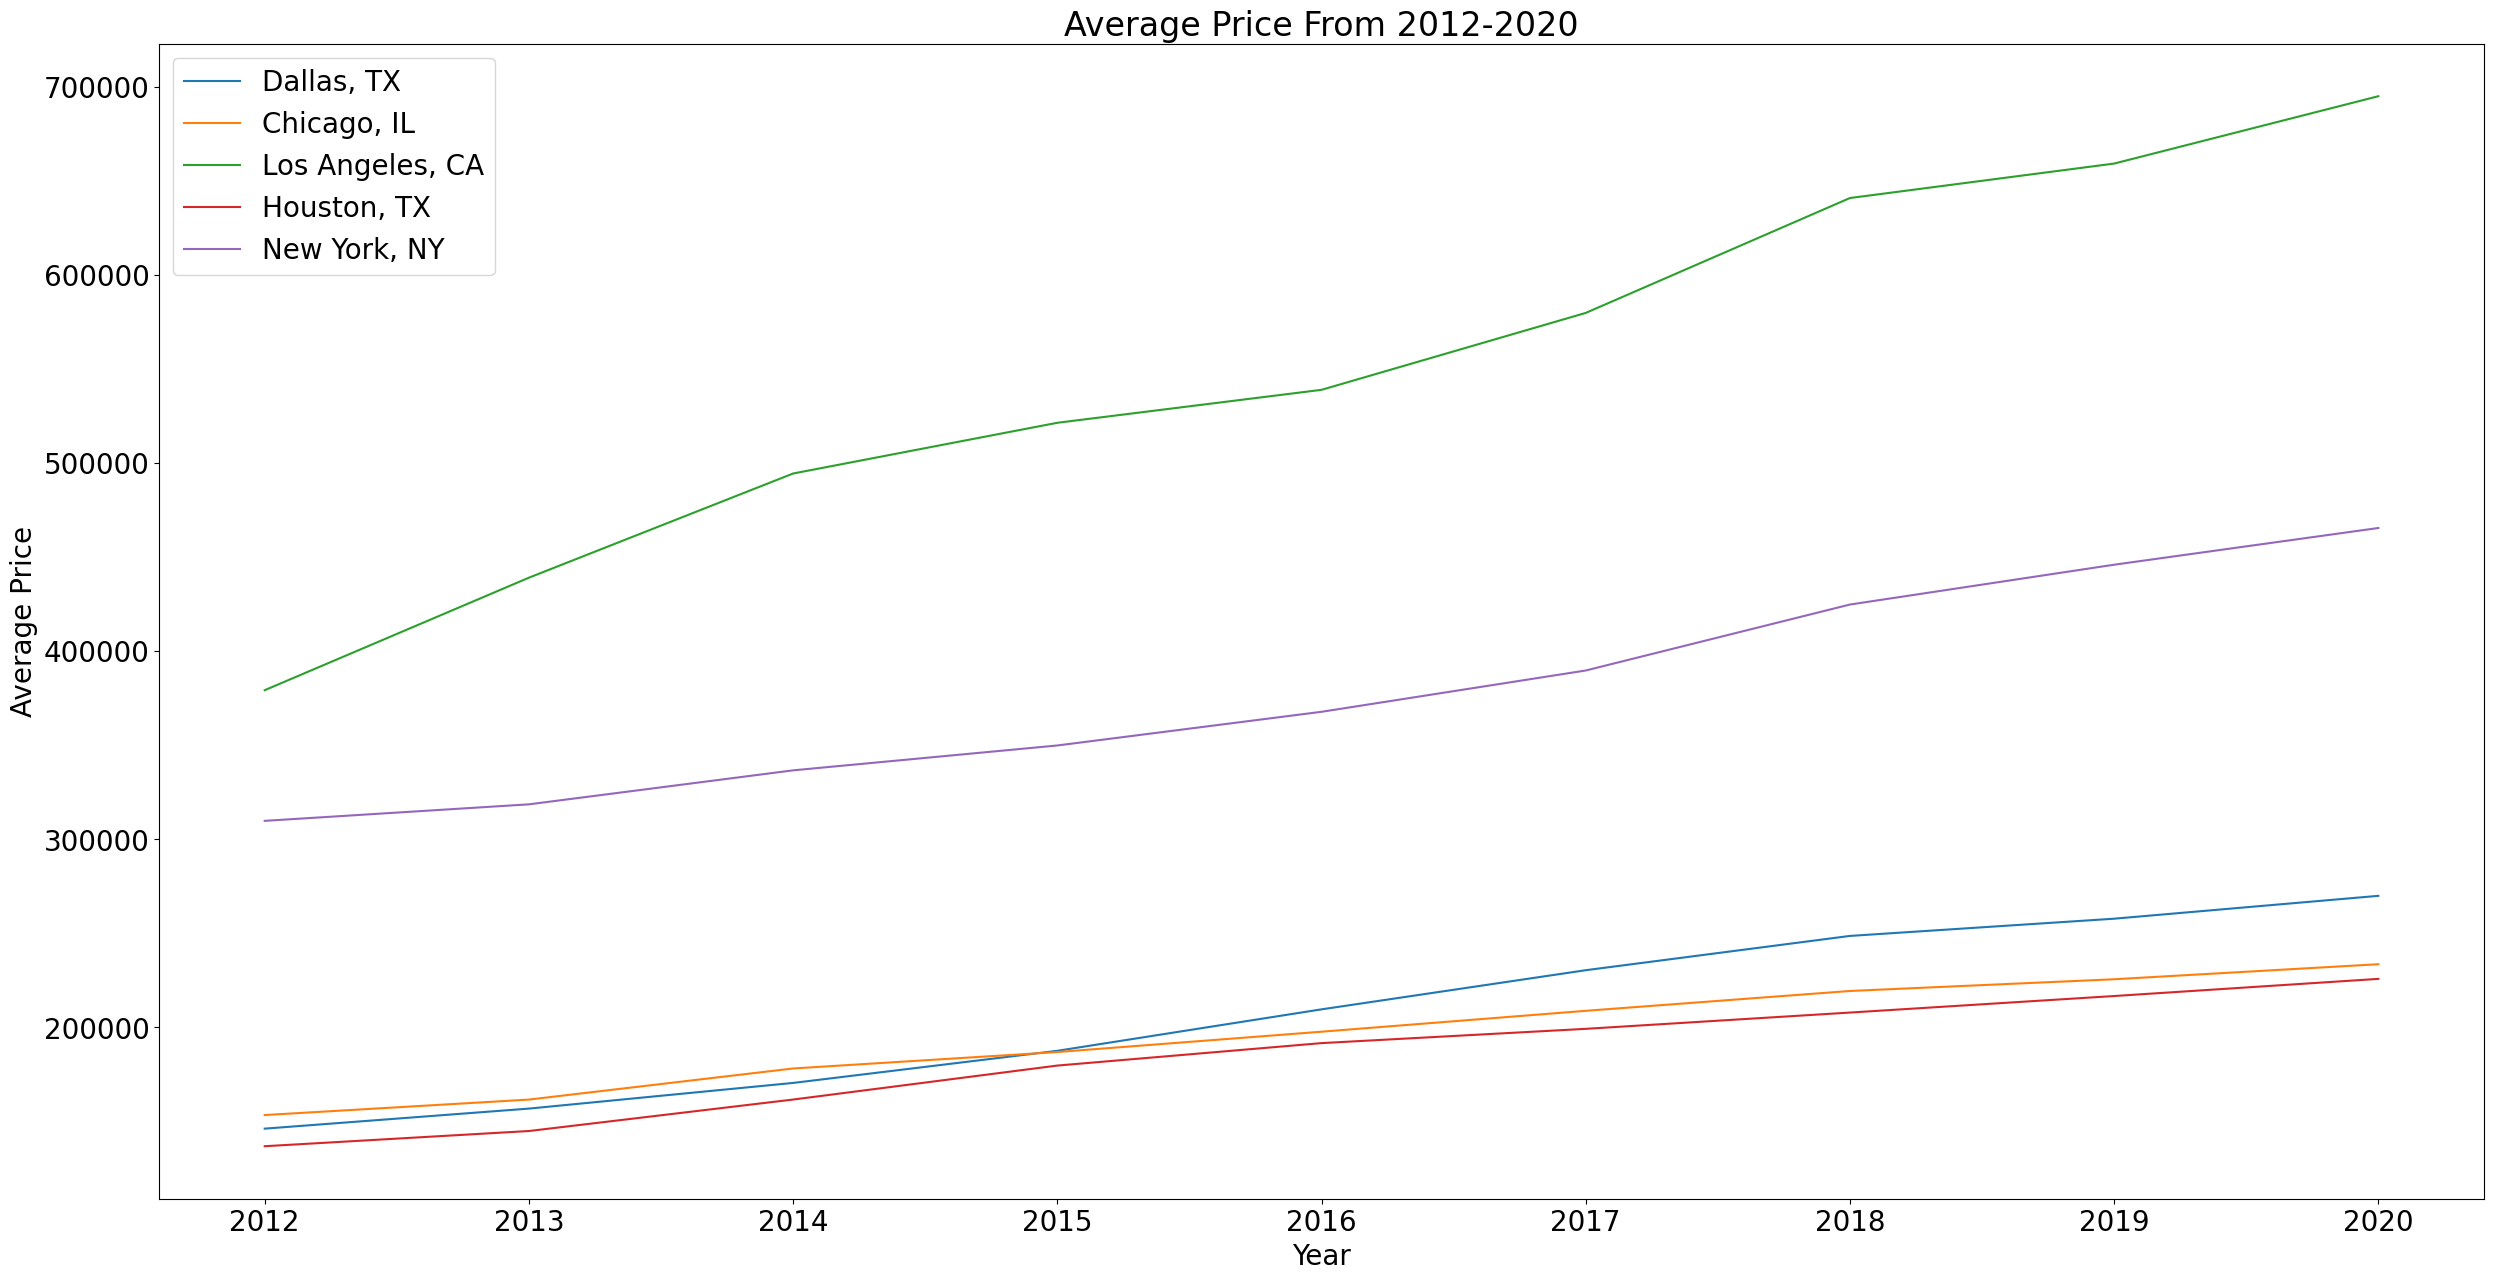

In [263]:
# Draw a line plot of Average Price From 2012-2020
city_set = set(final_df['City'])

plt.figure(figsize=(30,15)) 
for city in city_set:
     selected_data = final_df.loc[final_df['City'] == city]
     plt.plot(selected_data['Year'], selected_data['Average Price'], label=city)
    
plt.title("Average Price From 2012-2020")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.legend()
plt.show()

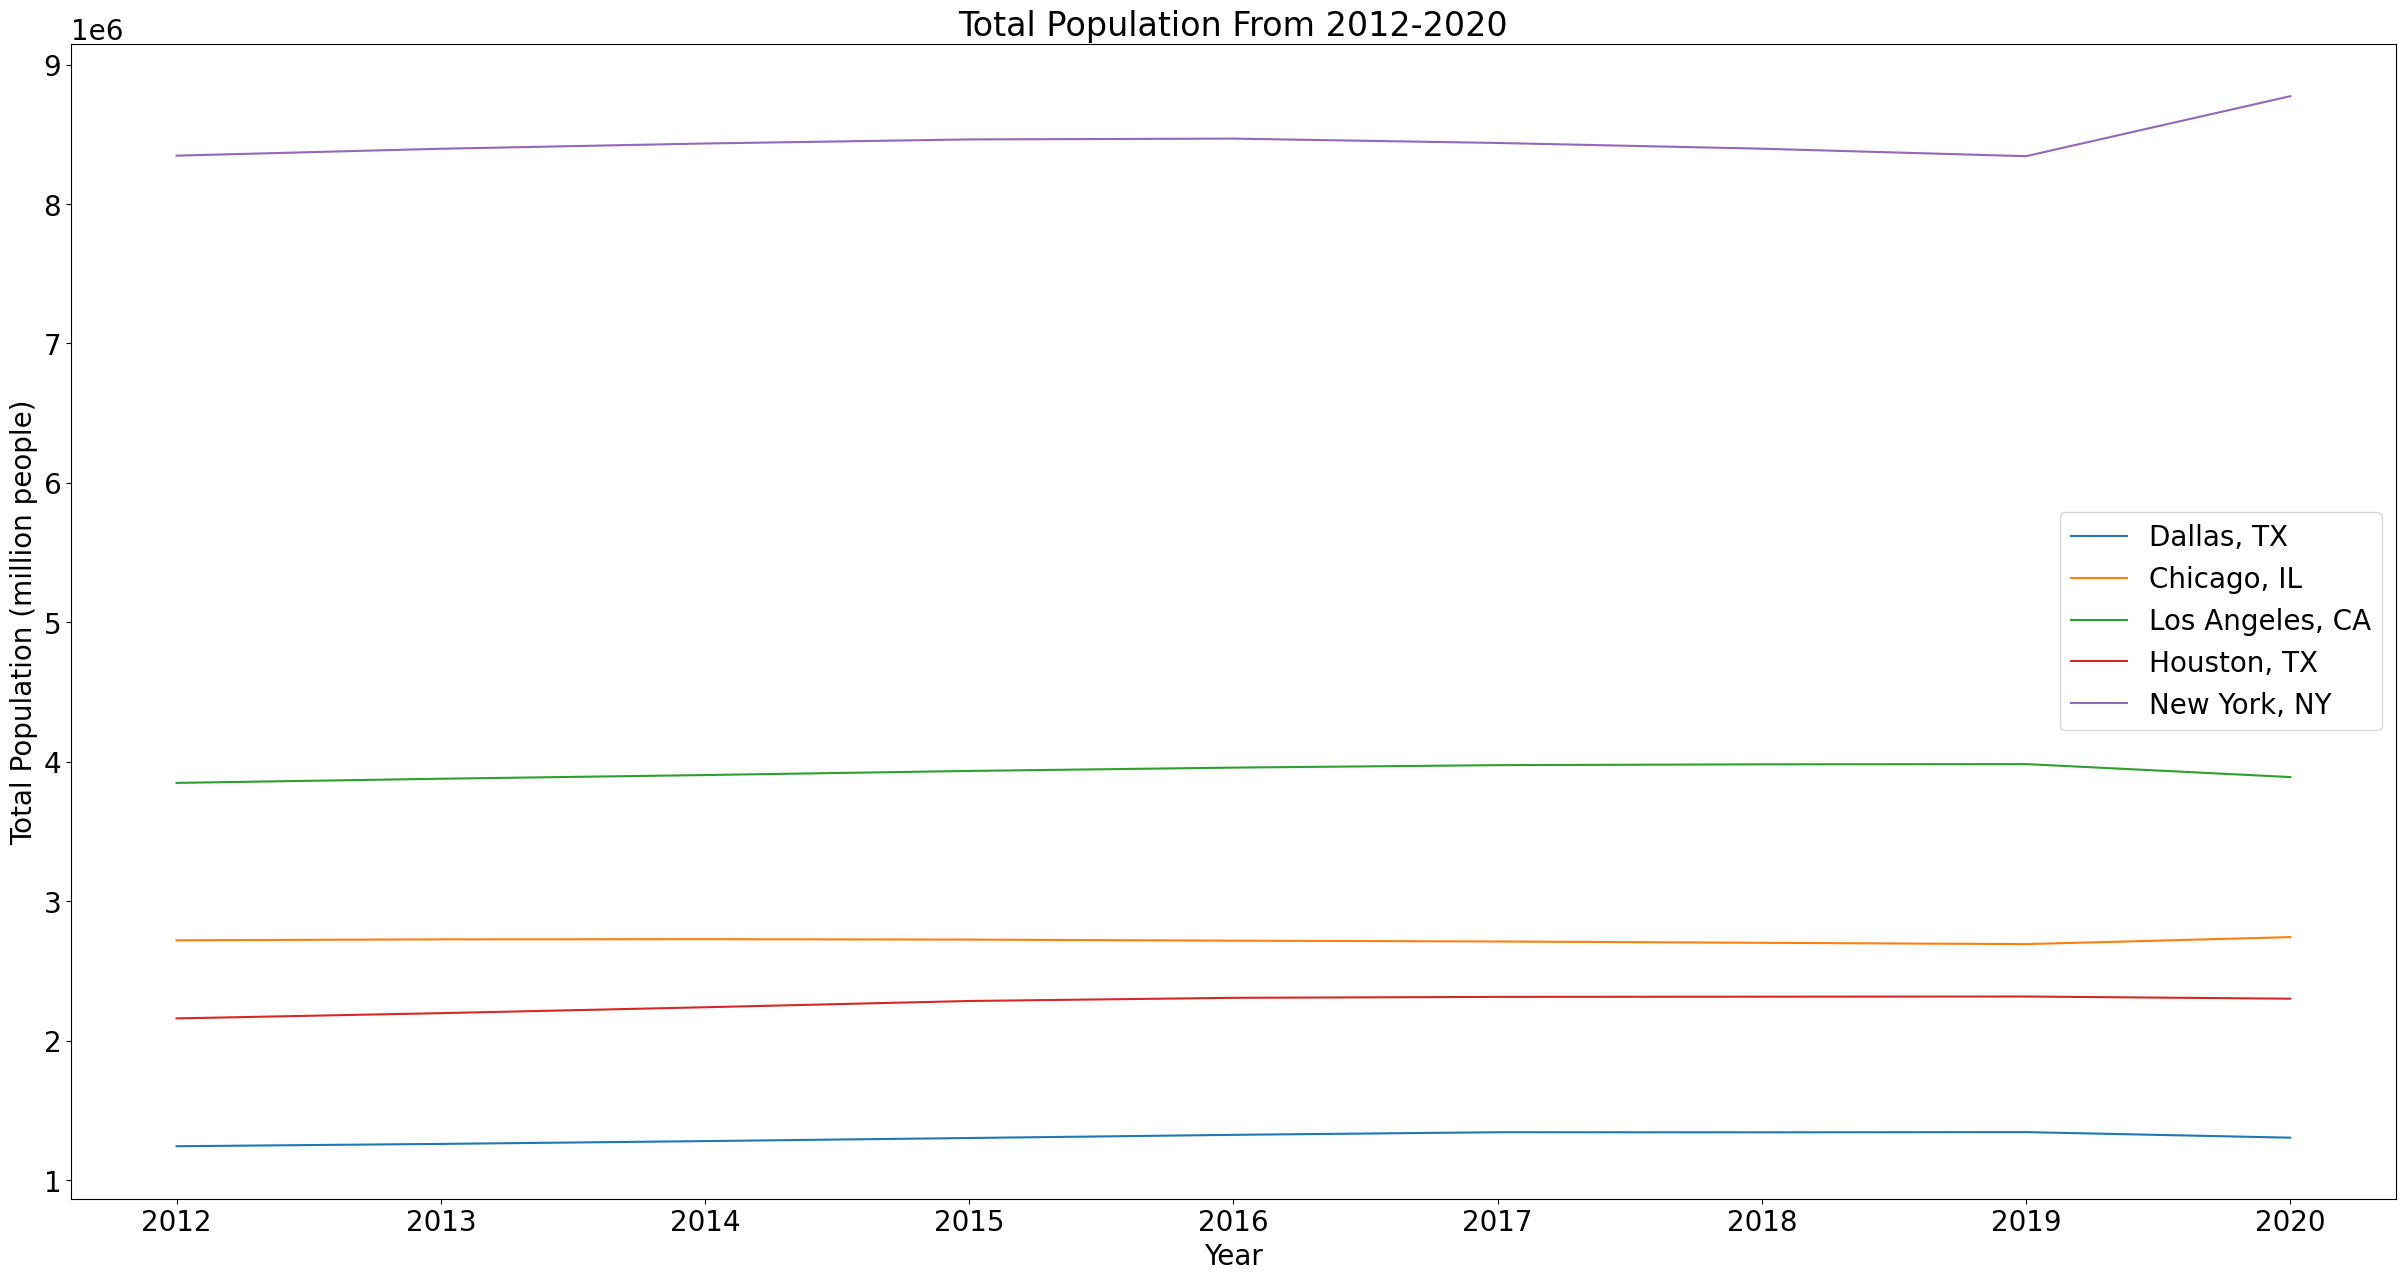

In [264]:
# Draw a line plot of Total Population From 2012-2020
city_set = set(final_df['City'])

plt.figure(figsize=(30,15)) 
for city in city_set:
     selected_data = final_df.loc[final_df['City'] == city]
     plt.plot(selected_data['Year'], selected_data['Total Population'], label=city)
    
plt.title("Total Population From 2012-2020")
plt.xlabel("Year")
plt.ylabel("Total Population (million people)")
plt.legend()
plt.show()

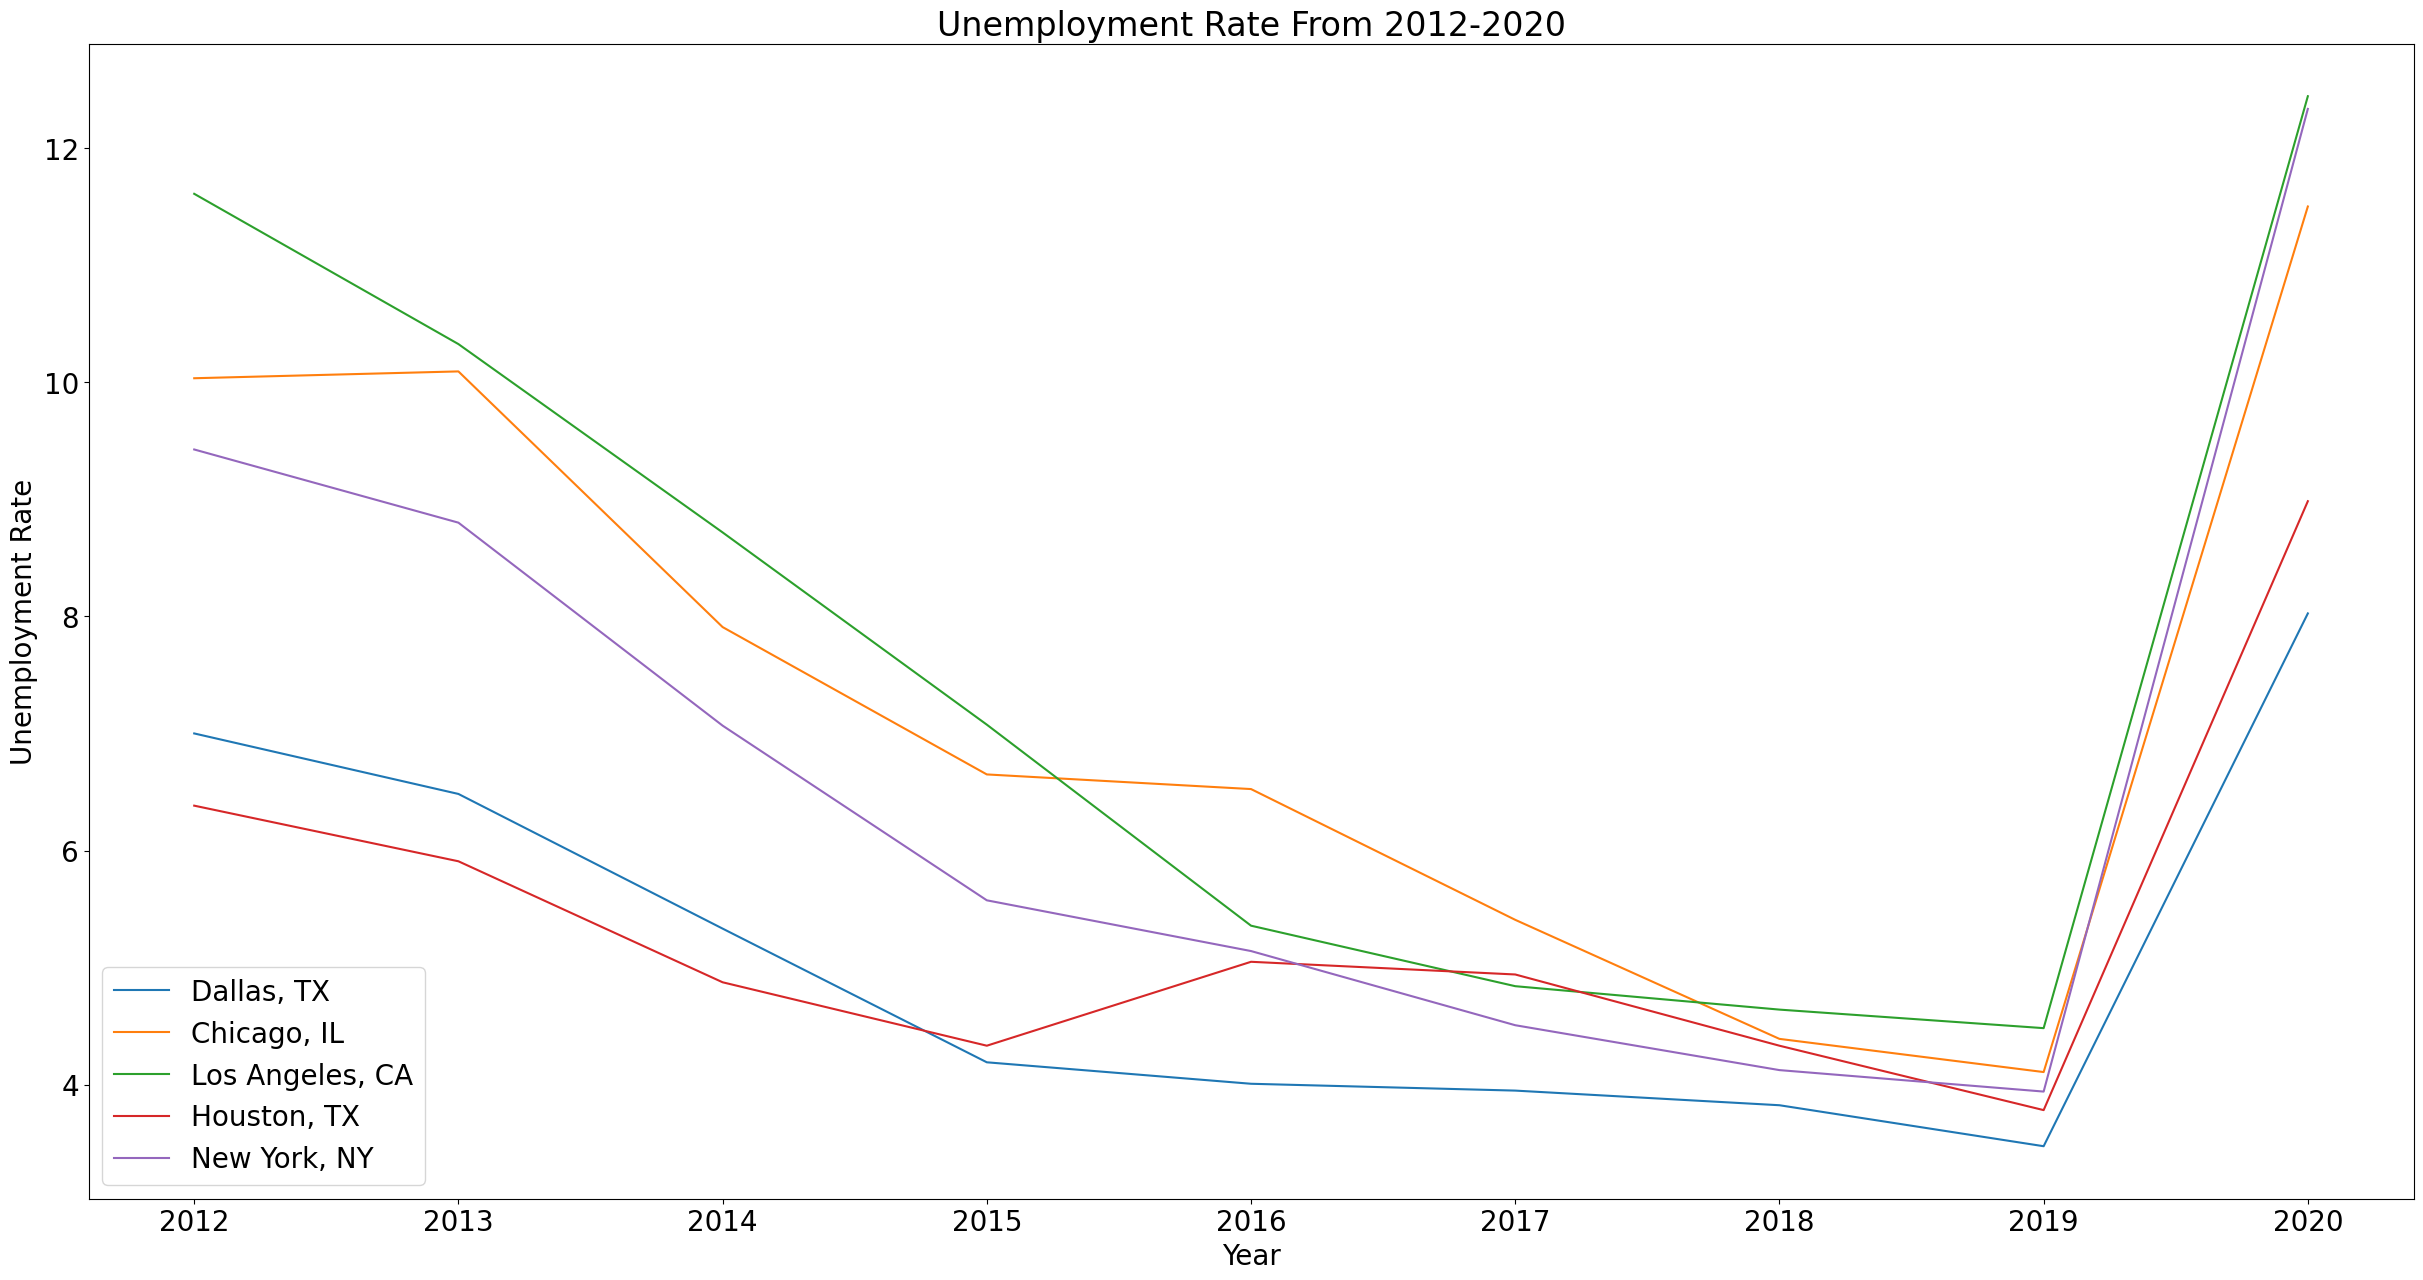

In [265]:
# Draw a line plot of Unemployment Rate From 2012-2020
city_set = set(final_df['City'])

plt.figure(figsize=(30,15)) 
for city in city_set:
     selected_data = final_df.loc[final_df['City'] == city]
     plt.plot(selected_data['Year'], selected_data['Unemployment Rate'], label=city)
    
plt.title("Unemployment Rate From 2012-2020")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate")
plt.legend()
plt.show()

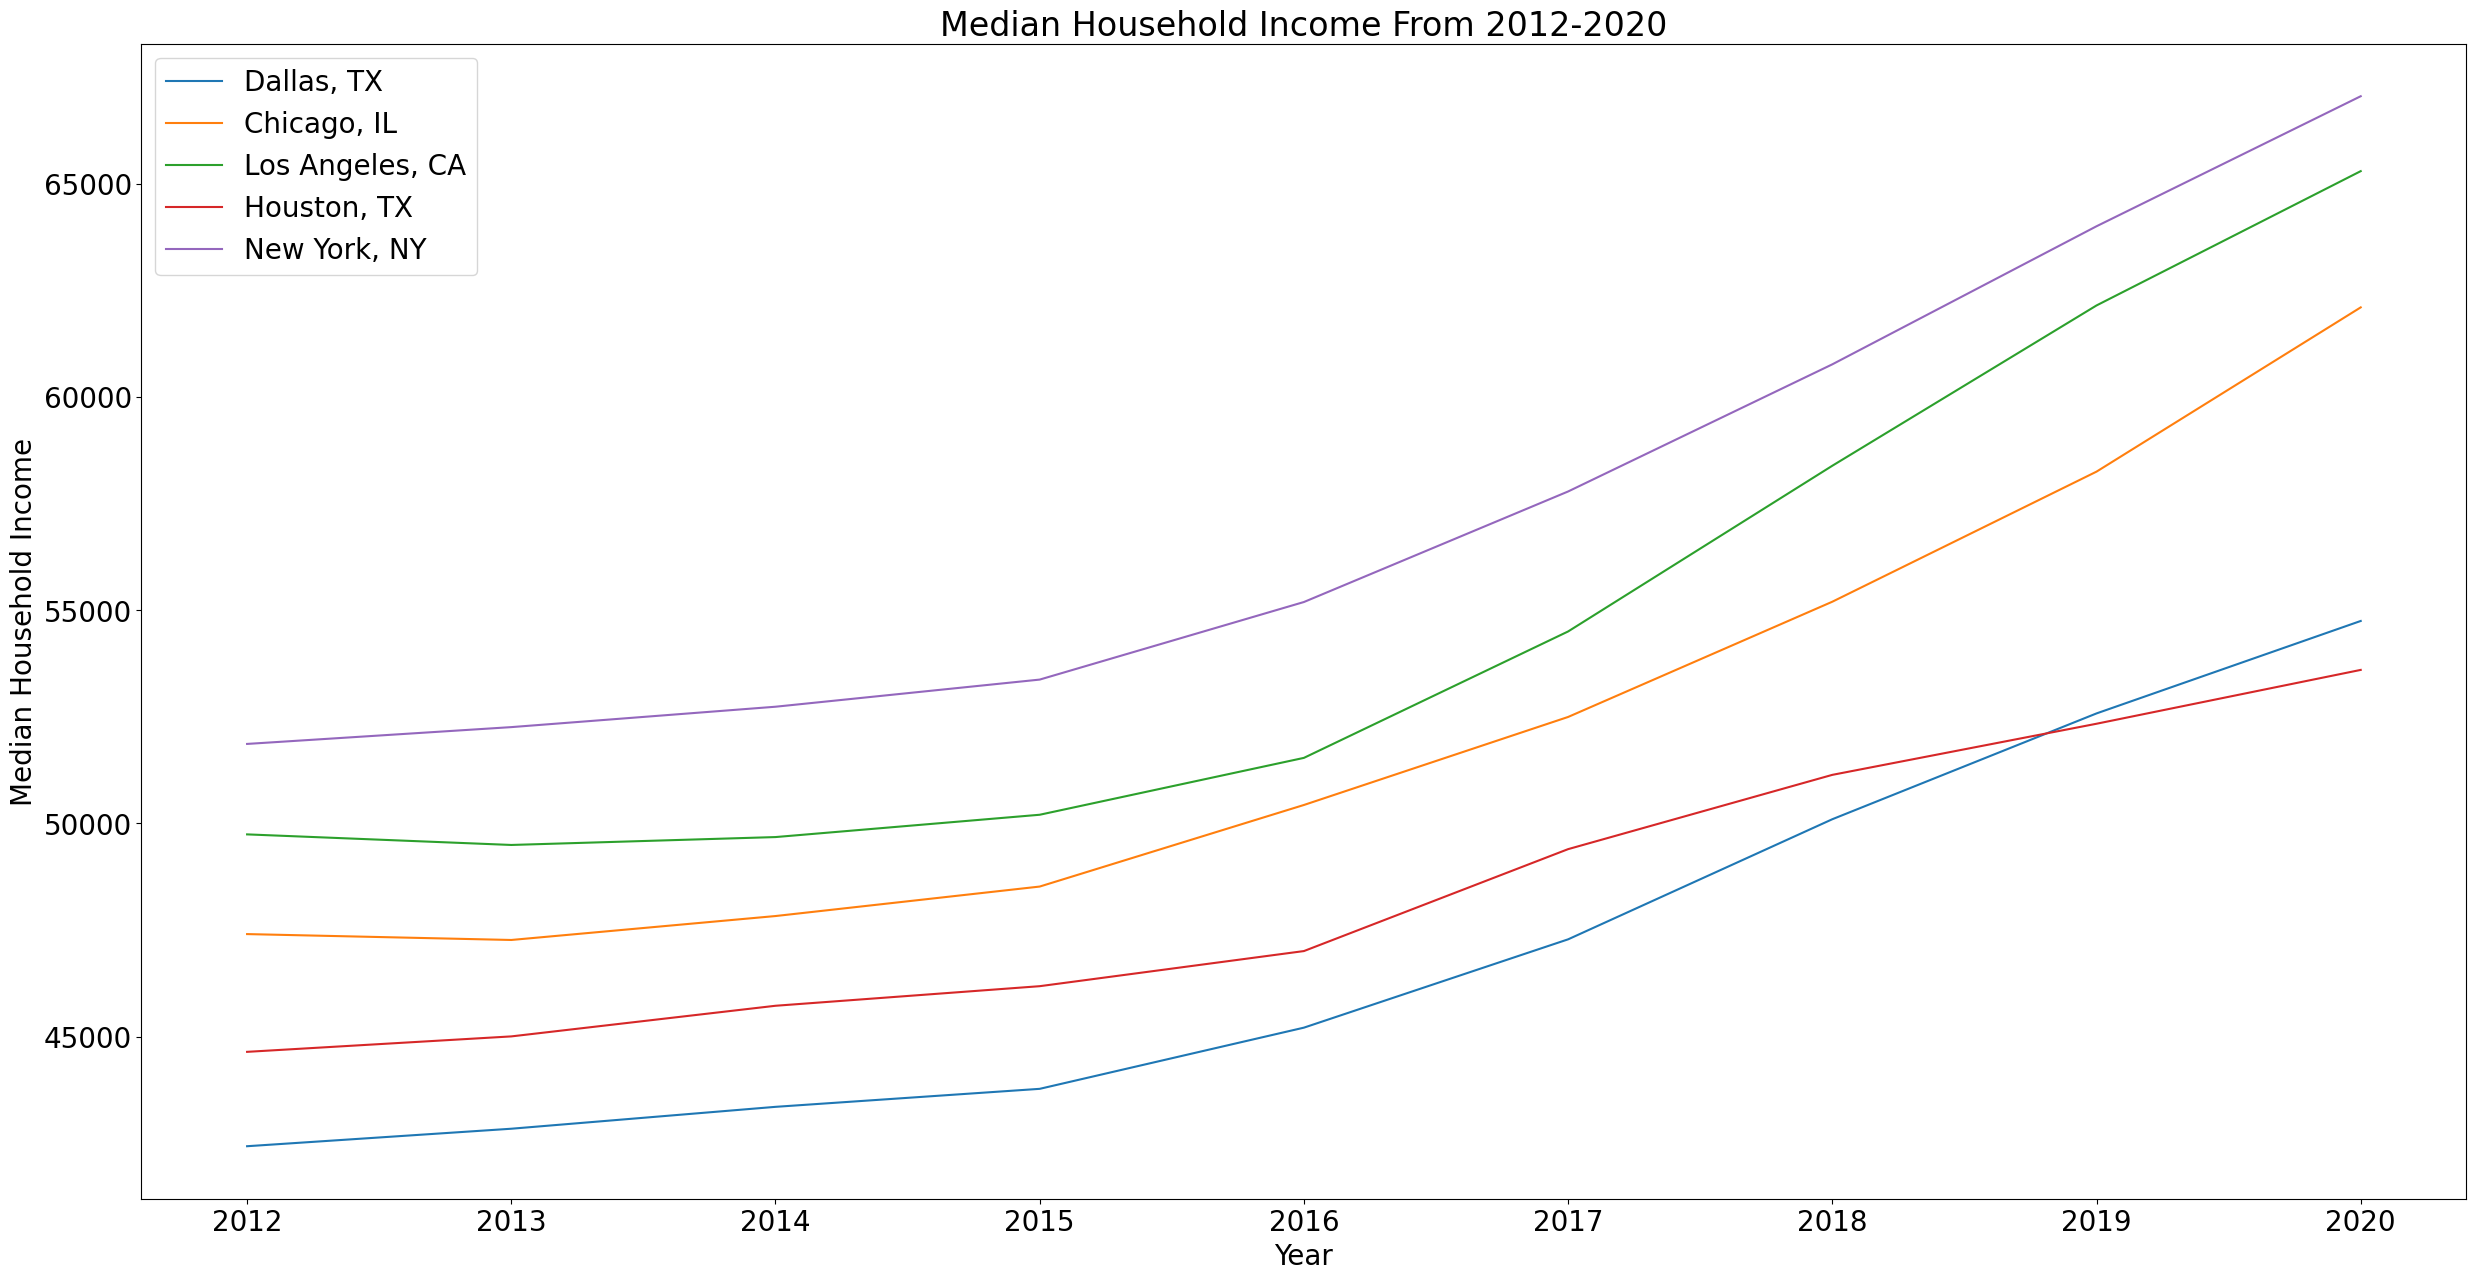

In [266]:
# Draw a line plot of Median Household Income From 2012-2020
city_set = set(final_df['City'])

plt.figure(figsize=(30,15)) 
for city in city_set:
     selected_data = final_df.loc[final_df['City'] == city]
     plt.plot(selected_data['Year'], selected_data['Median Household Income'], label=city)
    
plt.title("Median Household Income From 2012-2020")
plt.xlabel("Year")
plt.ylabel("Median Household Income")
plt.legend()
plt.show()

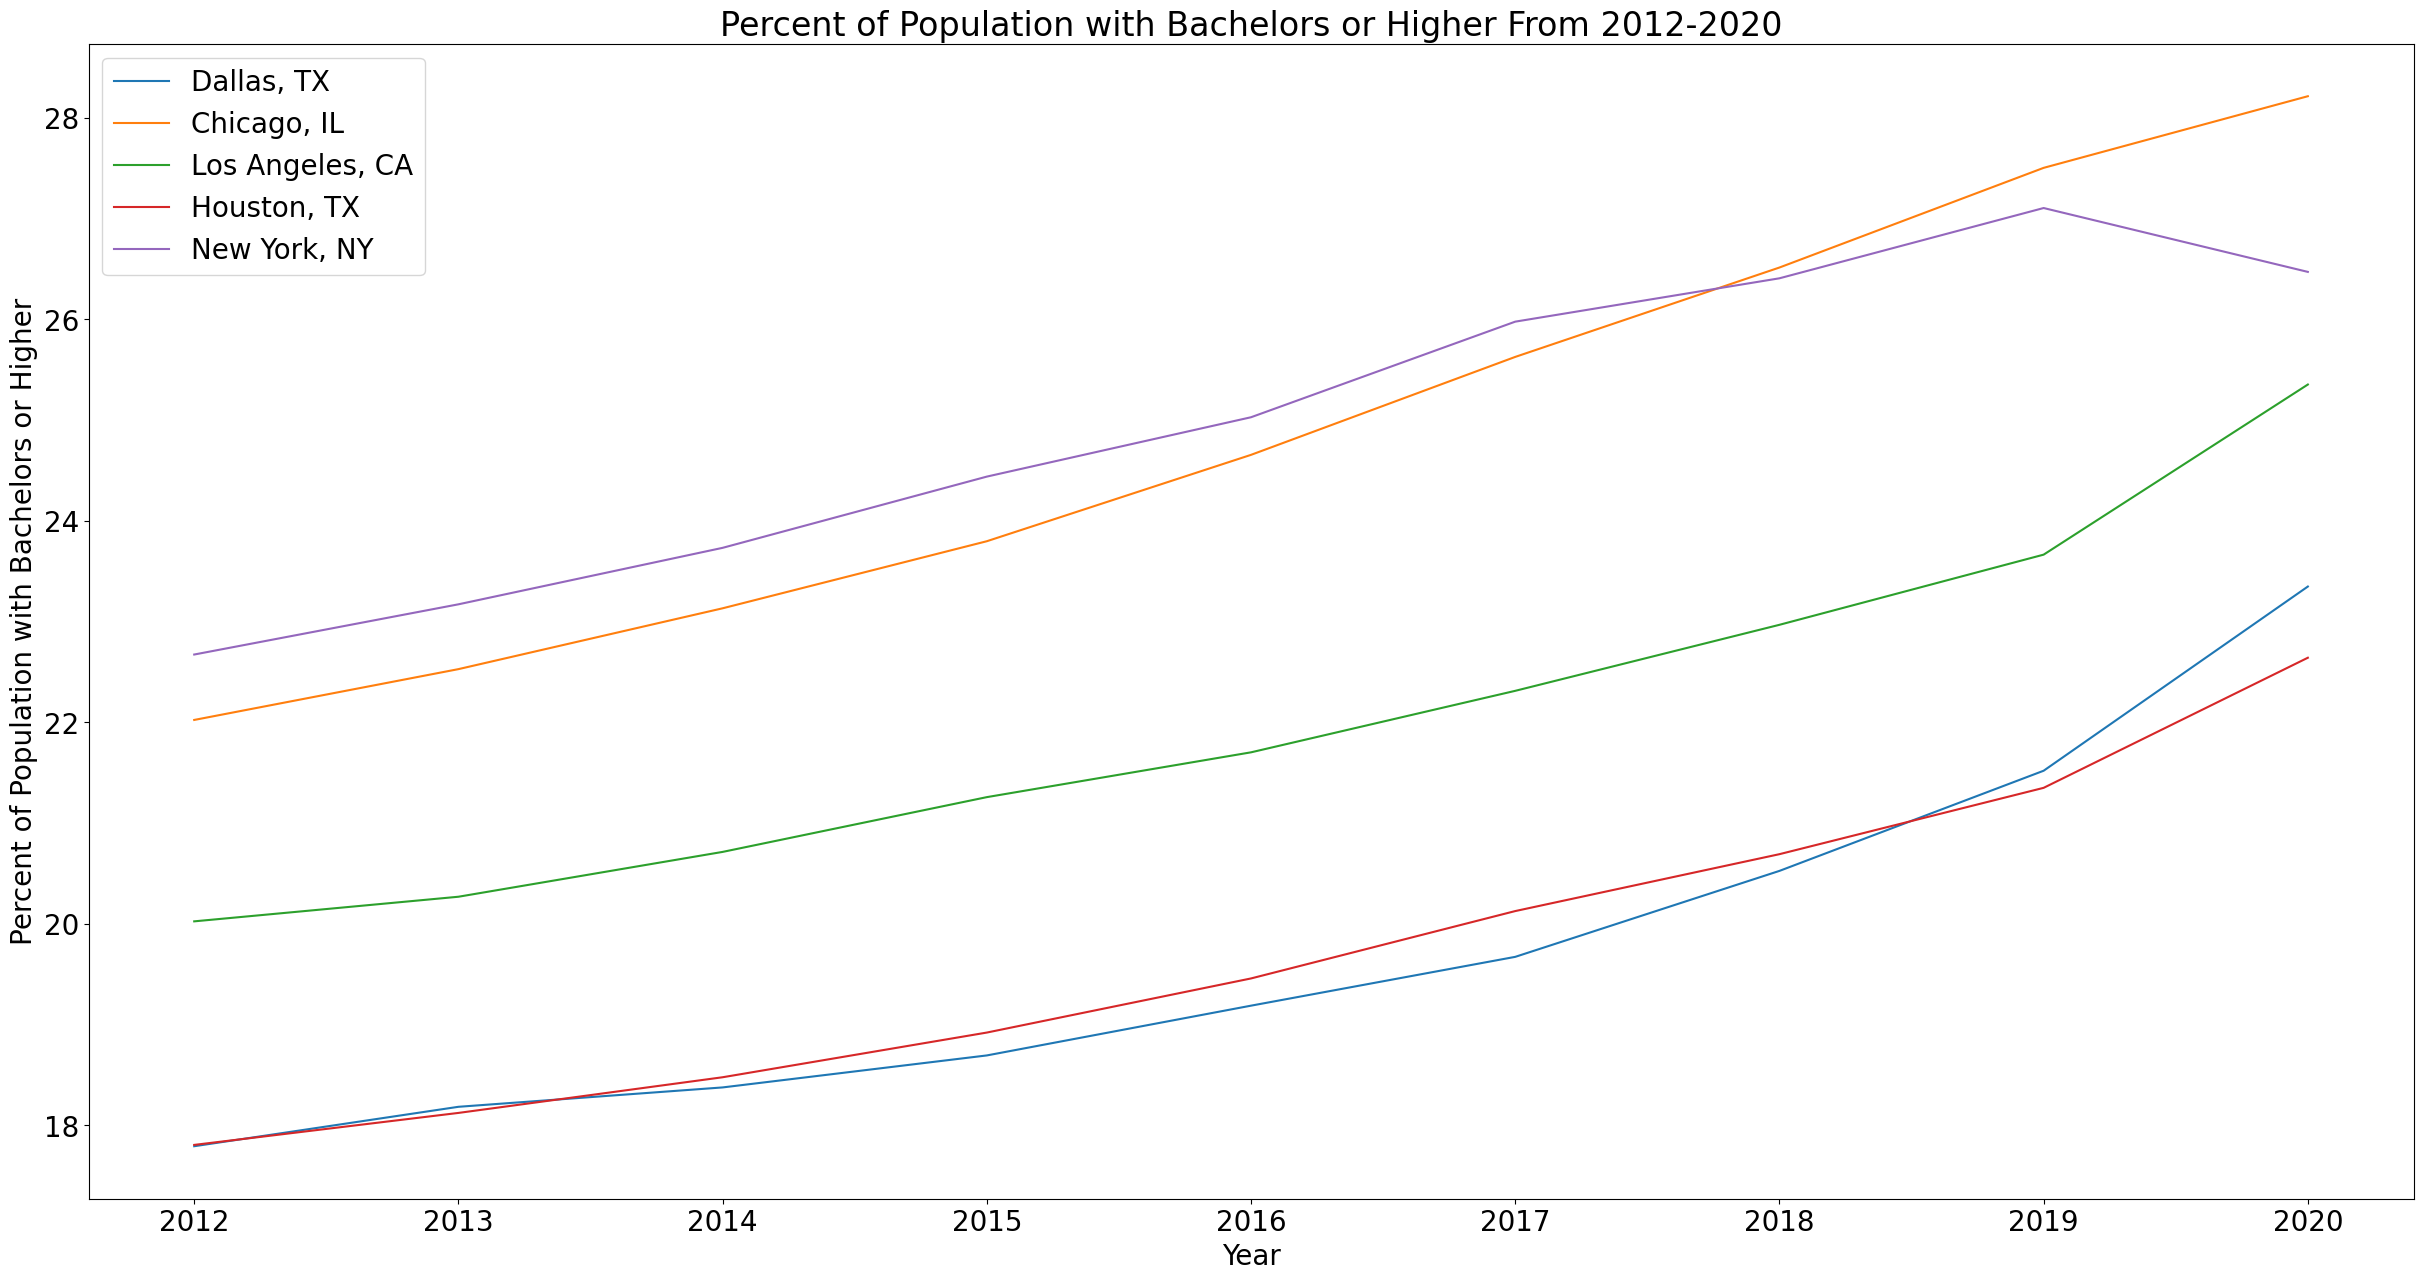

In [267]:
# Draw a line plot of Percent of Population with Bachelors or Higher From 2012-2020
city_set = set(final_df['City'])

plt.figure(figsize=(30,15)) 
for city in city_set:
     selected_data = final_df.loc[final_df['City'] == city]
     plt.plot(selected_data['Year'], selected_data['Percent of Population with Bachelors or Higher'], label=city)
    
plt.title("Percent of Population with Bachelors or Higher From 2012-2020")
plt.xlabel("Year")
plt.ylabel("Percent of Population with Bachelors or Higher")
plt.legend()
plt.show()

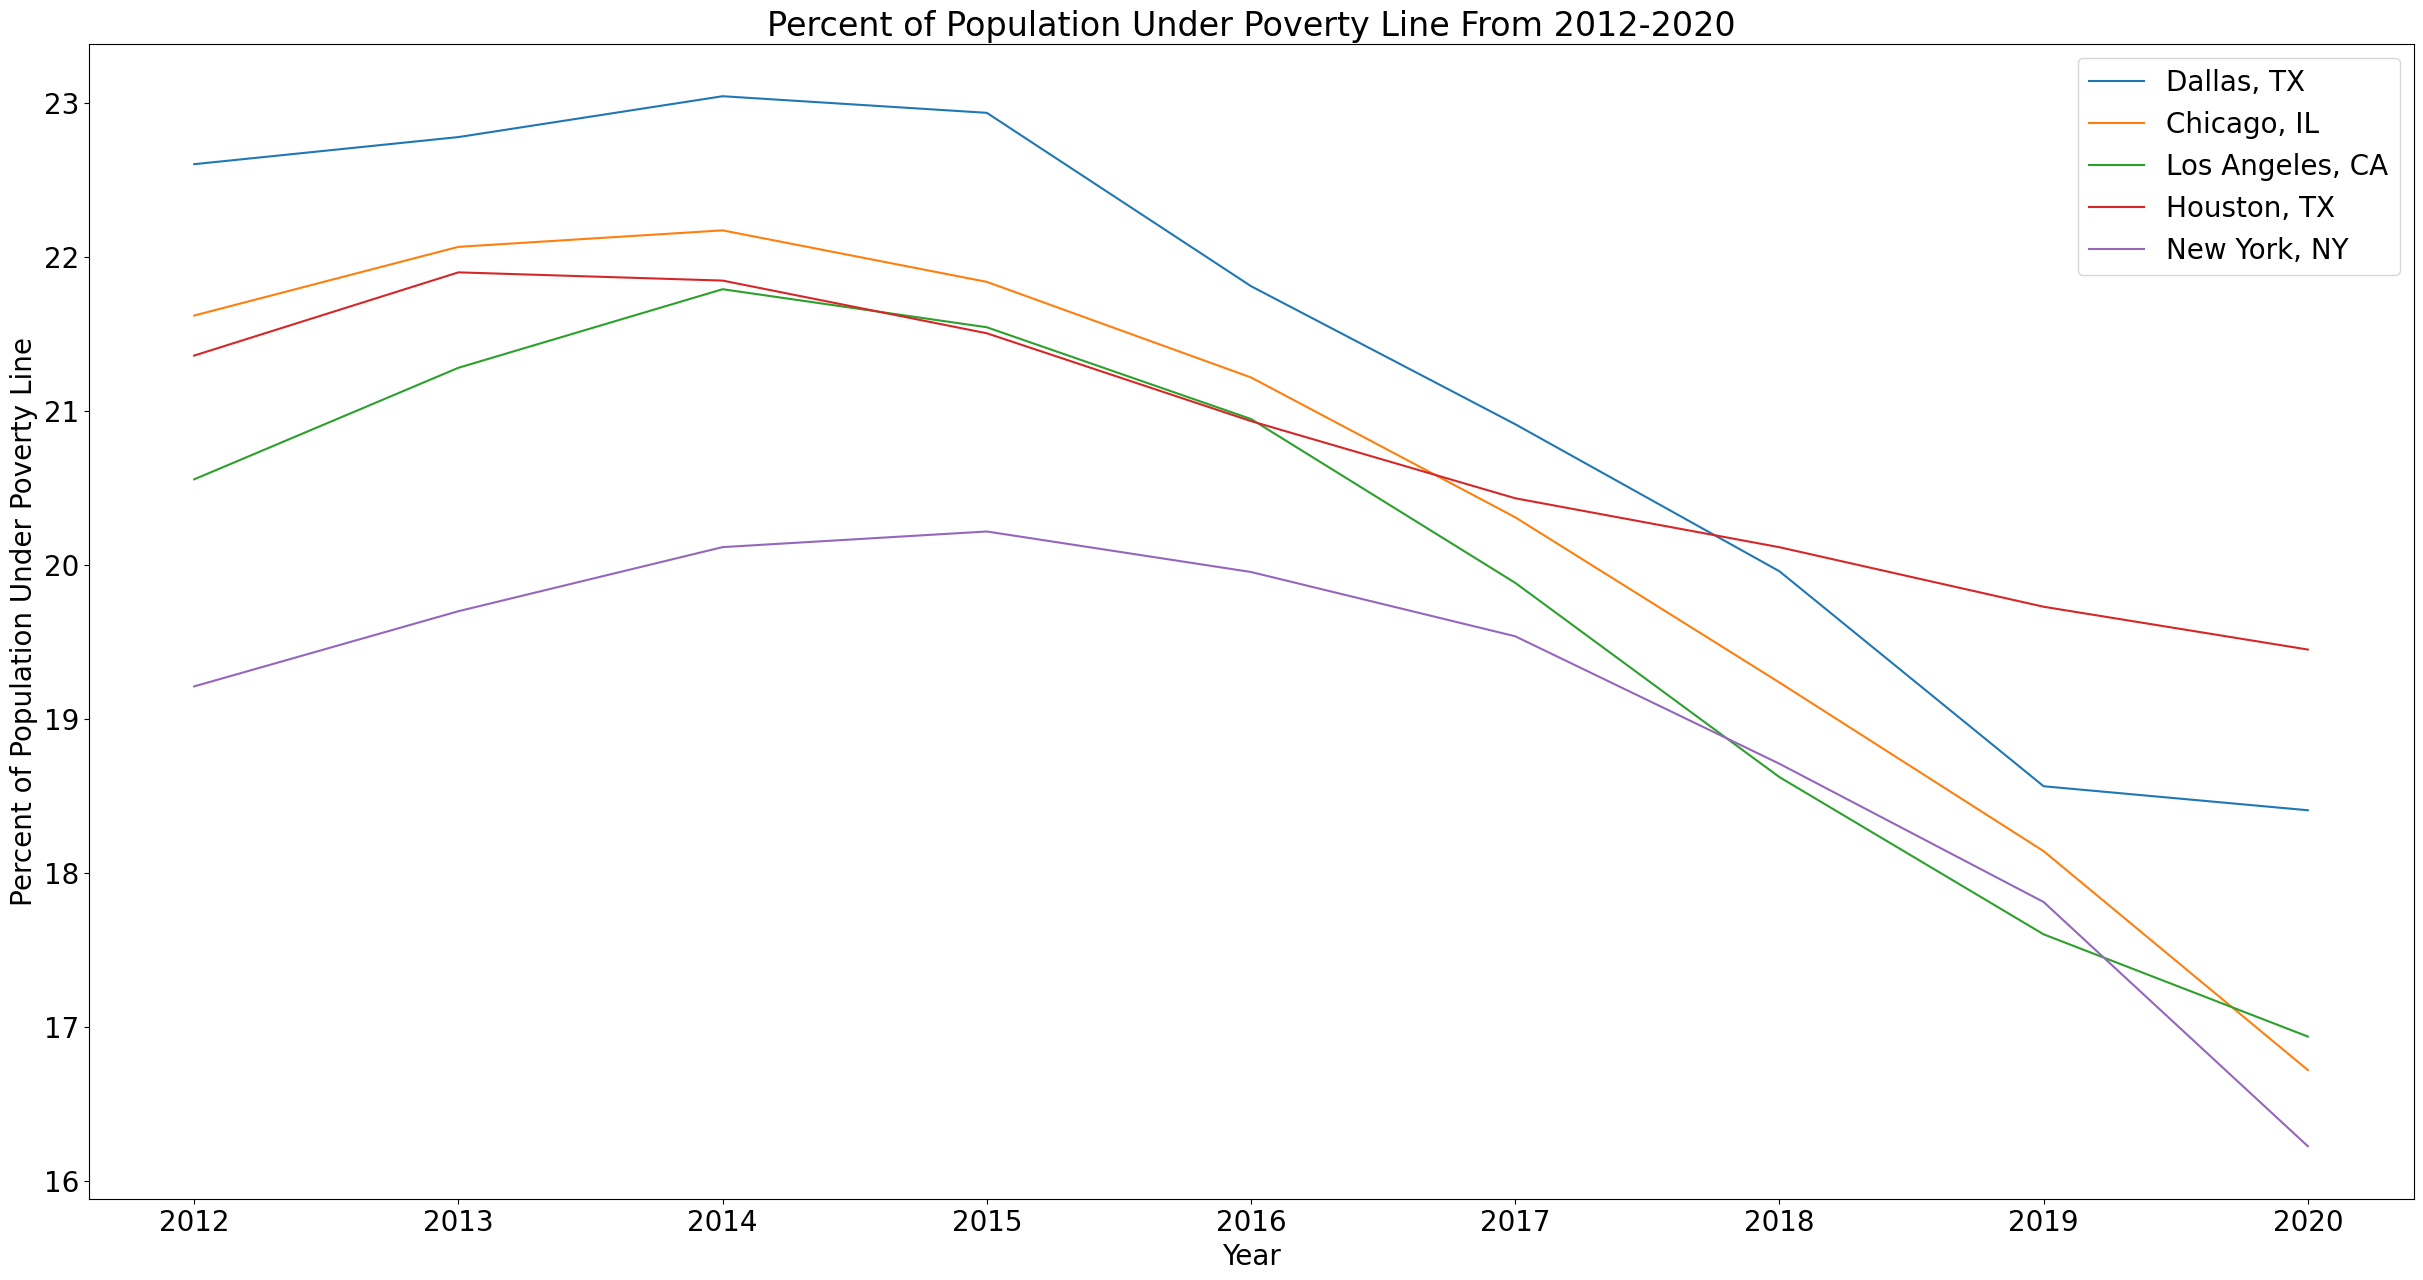

In [268]:
# Draw a line plot of Percent of Population Under Poverty Line From 2012-2020
city_set = set(final_df['City'])

plt.figure(figsize=(30,15)) 
for city in city_set:
     selected_data = final_df.loc[final_df['City'] == city]
     plt.plot(selected_data['Year'], selected_data['Percent of Population Under Poverty Line'], label=city)
    
plt.title("Percent of Population Under Poverty Line From 2012-2020")
plt.xlabel("Year")
plt.ylabel("Percent of Population Under Poverty Line")
plt.legend()
plt.show()

From the graph above, we can know that the average price has been increasing from 2012-2020. Total Population 
doesn't change too much. Unemployment rate decerased and increased. Median household Income and Percent of Population with Bachelors increases consistently; Percent of Population Under Poverty Line decreases consistently from 2012-2020.

Since the average house price has a trend that is increasing constantly, we want to find out that what might be the reasons leads to the increaing price. So we are going to draw a correlation matrix to find out the relationships between those factors and average house price.

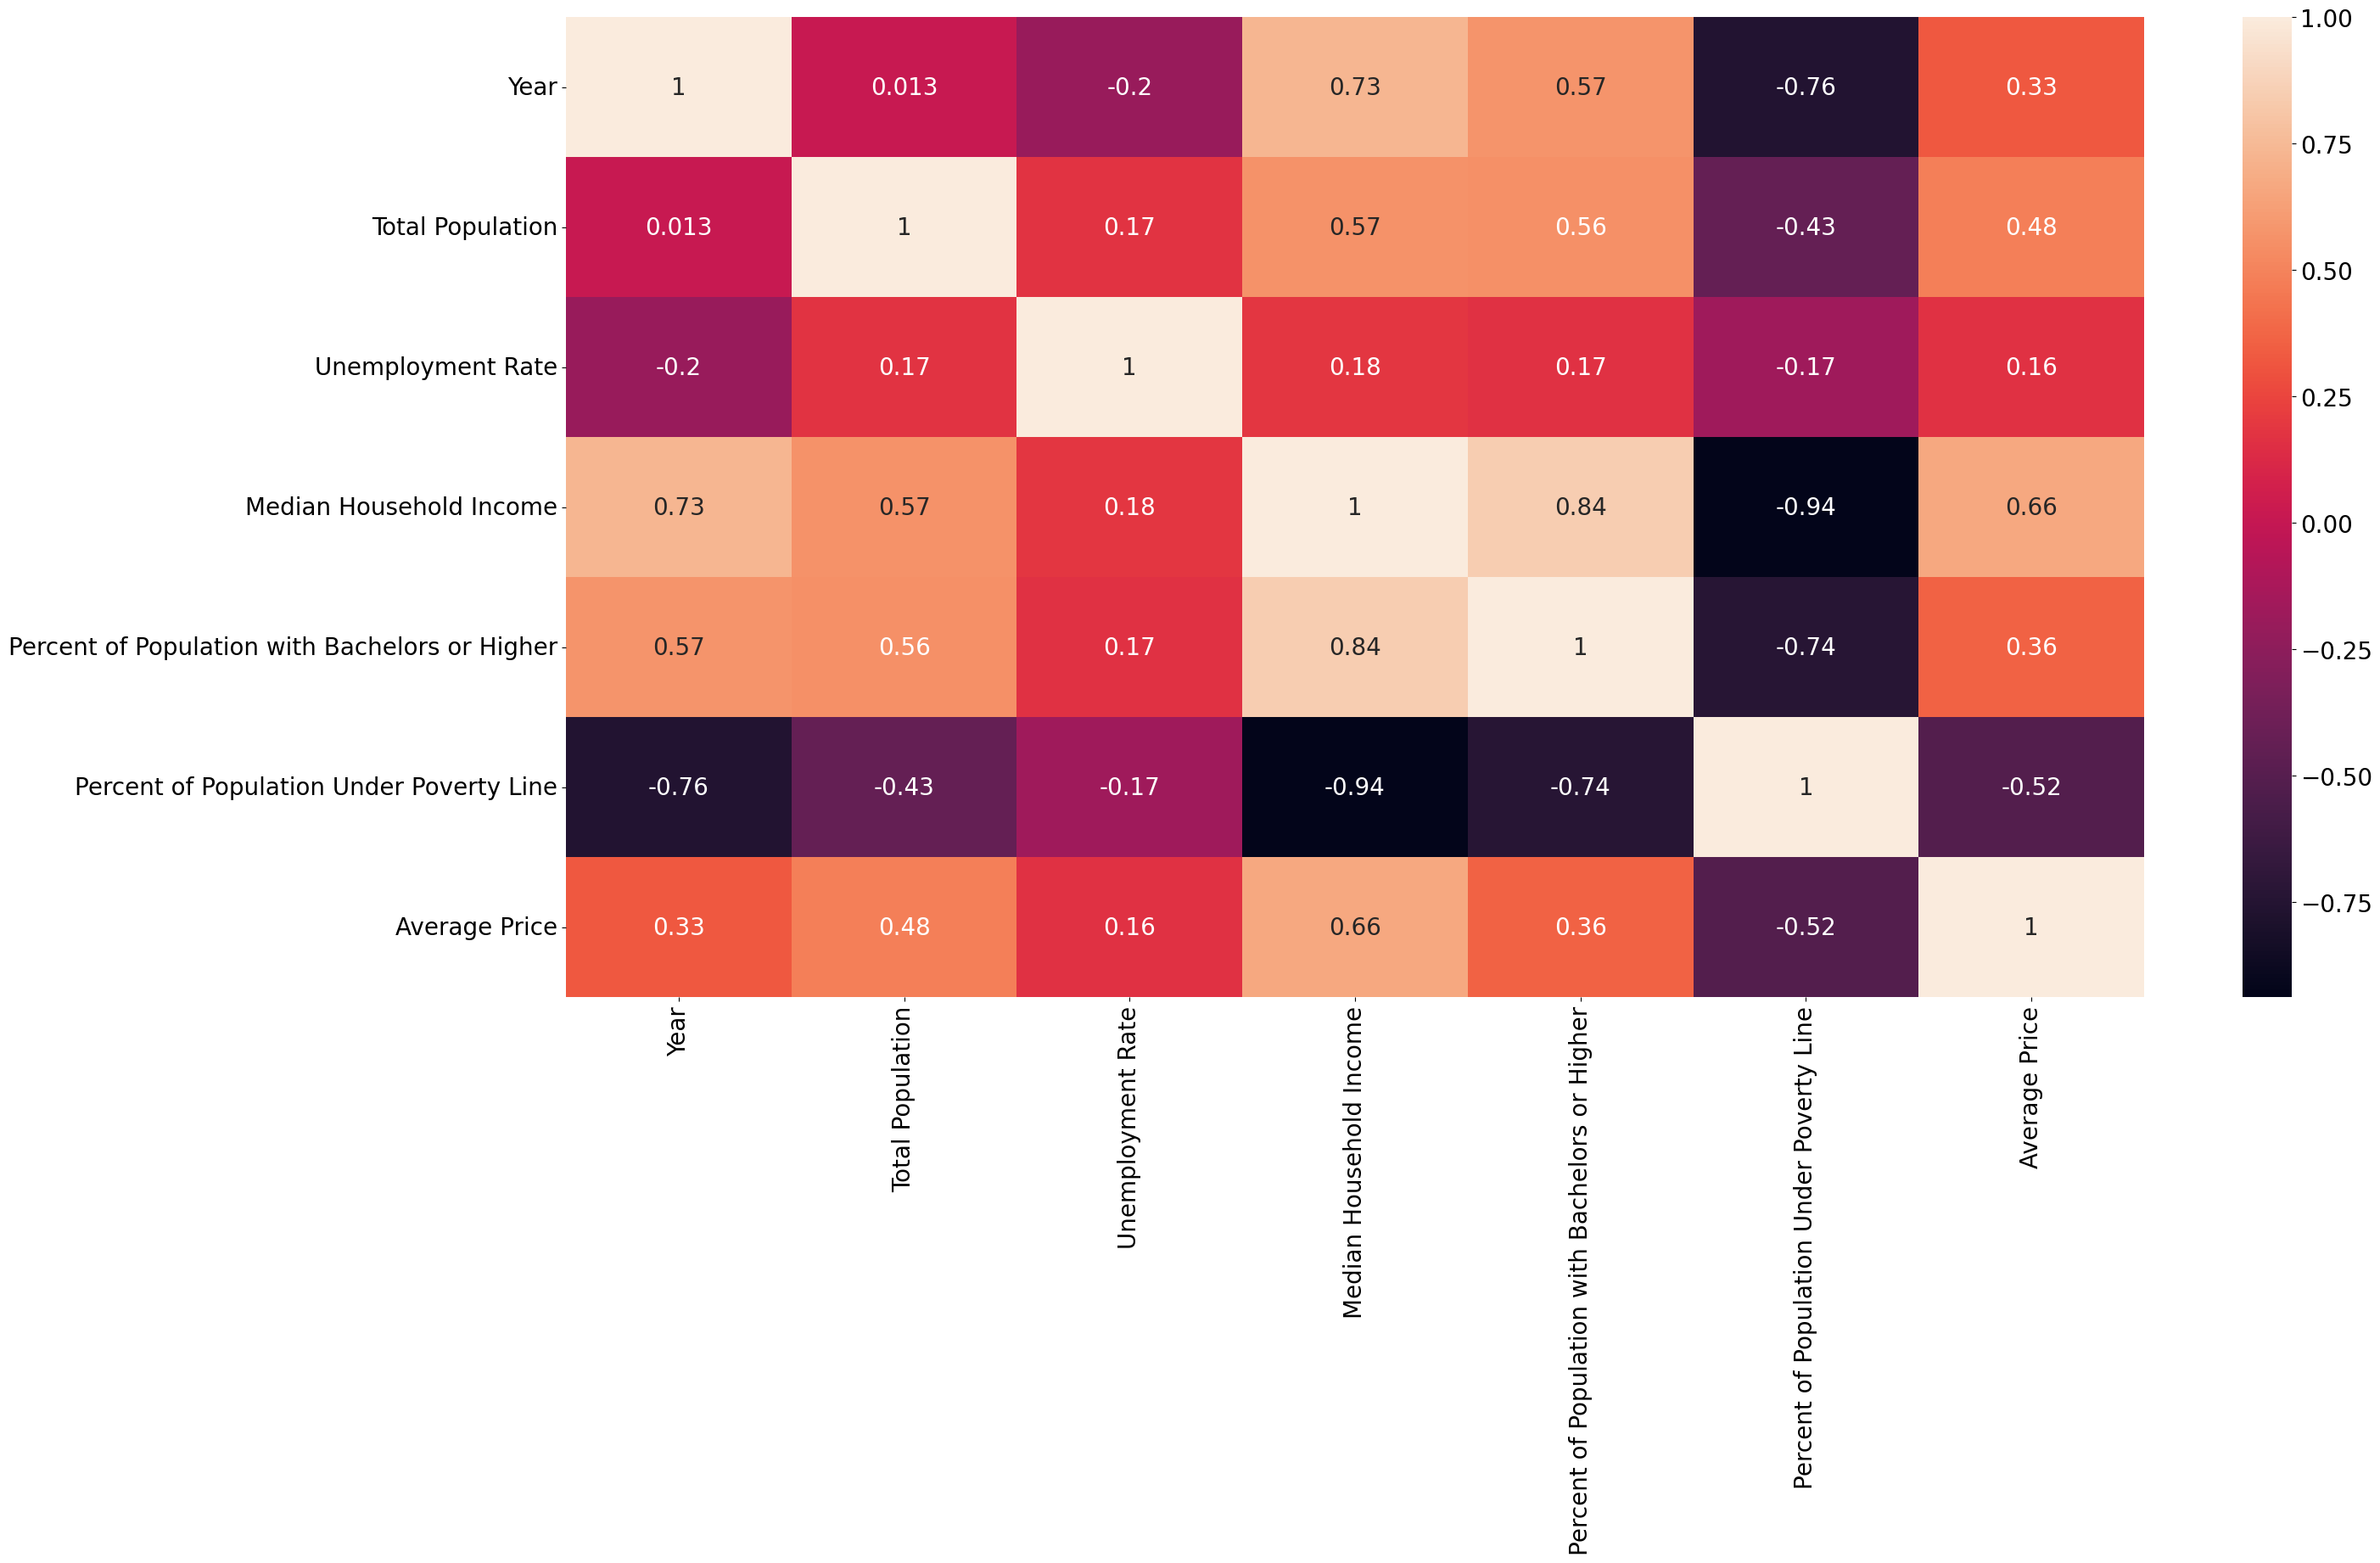

In [269]:
plt.figure(figsize=(30,15))
correlation_matrix = final_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

The correlation matrix shows us that there are 4 factors that might be able to impact the housing price. Those are:Year, Totoal Population, Median Household Income, Percent of Population with Bachelors or Higher, Percent of population Under Proverty. In these factor, Median Household Income has a strong relationship with Average price.

<font size="8" color="Black">Part 4</font>

We are going to build an initial regression model to predict the house price between differnet cities. 

In [270]:
final_df = final_df.rename(columns={
   'Total Population': 'total_population',
   'Unemployment Rate': 'unemployment_rate',
    'Median Household Income': 'median_household_income',
    'Percent of Population with Bachelors or Higher': 'percent_bachelors_or_higher',
    'Percent of Population Under Poverty Line': 'percent_under_poverty_line',
    'Average Price': 'average_price',
})

In [271]:
# Label encoding for the categorical variable 'City'
le = LabelEncoder()
final_df['City'] = le.fit_transform(final_df['City'])

# Defining predictors and target variable
X_initial = final_df[['City', 'total_population', 'median_household_income', 'percent_bachelors_or_higher', 
        'unemployment_rate', 'percent_under_poverty_line', 'Year']]
y = final_df['average_price']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, random_state=42)

# Defining the model
initial_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
initial_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = initial_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

MSE:  2202284562.198089
RMSE:  46928.50479397451


The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are both measures of model accuracy, with lower values indicating better performance.

The model's MSE is 2861185276.97, and the RMSE is 53490.05. The RMSE can be interpreted in the same units as the dependent variable, which in this case is the average house price. This means that, on average, your model's predictions are approximately $53,490 off from the actual house price.

In [272]:
average_predicted_price = np.mean(y_pred)
print("The average predicted house price is: ", average_predicted_price)

The average predicted house price is:  342289.78632498893


We got our model, to verify its validity, we are going to do some predictions for the house price in the New York City.

In [273]:
# Assuming you have a new data point for the new city
new_city_data = {'City': [4], 'total_population': [8433867], 'median_household_income': [63998], 
                 'percent_bachelors_or_higher': [0.27351827], 'unemployment_rate': [0.441667], 
                 'percent_under_poverty_line': [0.17116053], 'Year': [2023]}

new_df = pd.DataFrame(new_city_data)

# Convert all 'City' values in the original dataframe to strings and perform label encoding
final_df['City'] = final_df['City'].astype(str)
le = LabelEncoder()
final_df['City'] = le.fit_transform(final_df['City'])

# Separate predictors and target variable for the original data and train the model
X_initial = final_df[['City', 'total_population', 'median_household_income', 'percent_bachelors_or_higher', 
        'unemployment_rate', 'percent_under_poverty_line', 'Year']]
y = final_df['average_price']

# Fit the model
initial_model.fit(X_initial, y)

# Convert 'City' in new data to string, encode it and make a prediction
new_df['City'] = new_df['City'].astype(str)
new_city_encoded = le.transform(new_df['City'])
new_df['City'] = new_city_encoded

# Now you can predict the house price for the new city
new_city_prediction = initial_model.predict(new_df)

# Print out the prediction
print("Predicted average house price for the new city: ", new_city_prediction[0])

Predicted average house price for the new city:  473217.23922716186


Let's try some tactics that might be able to improve the accruary of the prediction model. First try Feature Engineering strategy.

In [274]:
final_df['income_per_population'] = final_df['median_household_income'] / final_df['total_population']
final_df['population_bachelors_interaction'] = final_df['total_population'] * final_df['percent_bachelors_or_higher']
final_df['population_squared'] = final_df['total_population'] ** 2

In [275]:
# Don't forget to add the new feature to the new city data as well
new_df['income_per_population'] = new_df['median_household_income'] / new_df['total_population']
new_df['population_bachelors_interaction'] = new_df['total_population'] * new_df['percent_bachelors_or_higher']
new_df['population_squared'] = new_df['total_population'] ** 2

# Redefine feature set to include the new feature
X_new = final_df[['City', 'total_population', 'median_household_income', 
              'percent_bachelors_or_higher', 'unemployment_rate', 'percent_under_poverty_line',  
              'Year', 'income_per_population', 'population_bachelors_interaction', 'population_squared']]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Defining the model
new_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
new_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = new_model.predict(X_test)


# Now you can predict the house price for the new city using the updated model
new_city_prediction = new_model.predict(new_df)

# Print out the prediction
print("Predicted average house price for the new city: ", new_city_prediction[0])

Predicted average house price for the new city:  409011.44185124204


We want to know which model is better suits for our circumstance, so we are going to compare their Cross-validation (This helps to evaluate the model's performance more robustly).

In [276]:
# Perform cross-validation
scores = cross_val_score(initial_model, X_initial, y, cv=5, scoring='neg_mean_squared_error')

# Print out the mean of the cross-validation scores
print("Cross-validated MSE: ", -scores.mean())

# Perform cross-validation
scores = cross_val_score(new_model, X_new, y, cv=5, scoring='neg_mean_squared_error')

# Print out the mean of the cross-validation scores
print("Cross-validated MSE: ", -scores.mean())

Cross-validated MSE:  36214328159.20153
Cross-validated MSE:  39831493902.30622


After comparing the Cross-validated MSE, we want to choose the one that has a smaller number (it has a smaller error, meaning its predictions are, on average, closer to the actual values.), so we are actully going to use the model before reenforcement, which is the initial_model

<font size="8" color="Black">Part 5</font>

<font size="8" color="Black">Part 6</font>